In [131]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from surprise import *
from surprise import accuracy
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from collections import defaultdict

In [132]:
# import dataset
data = pd.read_csv("data/azure/BB_user_ratings.csv")
data

,ACCOUNT_NUM.hash,package,ratings
0,729e0a0a75015a8908d0989386f4454e,Web Family Xtra,0.000000
1,2f1d8e2ad12e57fce4419845e23ddcbd,Web Starter,0.175347
2,0d4098a262a8bed6ac4253f42dfc5769,Web LITE,0.072917
3,fac45c3800fe3b9a28cc124f692a9f4a,Student Package 1,0.000000
4,f53c729fa6b9ce93c6b4bb190efe41b3,Student Package 2,0.000000
...,...,...,...
1347,0fa1d2aeb386d52b8fb4b545f3d28b5d,Web Family Active,0.000000
1348,7db2aa38214037279601a314071d1972,Web LITE,0.326389
1349,019217a7950072f267ab6dcb0d790969,Broadband Experience Package,0.000000
1350,f5934060d1b7b0a329df4d29242225b8,Web PAL,0.567708


In [133]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1352 entries, 0 to 1351
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ACCOUNT_NUM.hash  1352 non-null   object 
 1   package           1352 non-null   object 
 2   ratings           1352 non-null   float64
dtypes: float64(1), object(2)
memory usage: 31.8+ KB


## Interaction Matrix

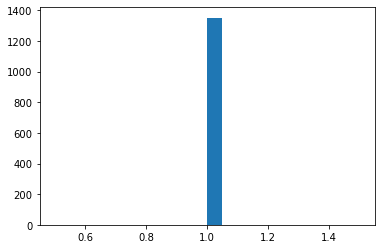

In [134]:
# create a histogram of all the interactions by all the users present in the dataset
interactions = data.groupby('ACCOUNT_NUM.hash').count()['package']
plt.hist(interactions,bins=20)
plt.show()

In [135]:
# create the user item matrix using the ratings dataset - Hint: try using pivot function 
interactions_metrix = data.pivot_table(index="ACCOUNT_NUM.hash", columns="package", values="ratings",aggfunc=np.sum)

In [136]:
interactions_metrix.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1352 entries, 00126426420cdb4b1fe951ce5bb3c05a to ffaaa3f5d45ce8c8553efbcfa7e6ce00
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   4G Basic                      1 non-null      float64
 1   4G Biz Pal                    1 non-null      float64
 2   Abhimaana                     9 non-null      float64
 3   Any Beat                      16 non-null     float64
 4   Any Blaze                     5 non-null      float64
 5   Any Flix                      12 non-null     float64
 6   Any Joy                       42 non-null     float64
 7   Any Spike                     1 non-null      float64
 8   Any Tide                      3 non-null      float64
 9   BB_Netflix Unlimited          1 non-null      float64
 10  Broadband Experience Package  61 non-null     float64
 11  Entree                        44 non-null     float64
 12  PACKAGE 

In [137]:
# replace all the missing values with zero
interactions_metrix = interactions_metrix.fillna(0)

In [138]:
interactions_metrix.sample(n=10)

package,4G Basic,4G Biz Pal,Abhimaana,Any Beat,Any Blaze,Any Flix,Any Joy,Any Spike,Any Tide,BB_Netflix Unlimited,...,Web Family Xtra,Web LITE,Web Master,Web PAL,Web Pro,Web Starter,z Sales End_Home,z Sales End_Office,z Sales End_SLT Staff Home,z Sales End_Xcite
ACCOUNT_NUM.hash,,,,,,,,,,,,,,,,,,,,,
b3bd0820dbe08e095137b100bfc9725b,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
2e3aeb5561f7a9f02cc4d22b74c98a53,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.348958,0.0,0.000000,0.0,0.0,0.0,0.0
826604f55792074aee2537040d82ff5e,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.232639,0.0,0.0,0.0,0.0
aee5bc6be3b50afe66cde3095448e88b,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
ead1690a52c3ce6f120c5135db86cb9e,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
9c802b6b329dc1e3ba6e6c655a21e65d,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.593750,0.0,0.0,0.0,0.0
9593104a5b6451e4fbc4809cb45365ba,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
b281748996ed0ffd220f33b2ffffe3a8,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
17e6c3b8d8c8019469b7288f0ee6795f,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


In [139]:
reader = Reader(rating_scale=(0, 1))
data_model = Dataset.load_from_df(data, reader)

In [140]:
trainset, testset = train_test_split(data_model, test_size=.20)

## Collabarative Recoomenders with Surprise

In [141]:
def get_Iu(uid):
    """Return the number of items rated by given user
    
    Args:
        uid: The raw id of the user.
    Returns:
        The number of items rated by the user.
    """
    
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError:  # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """Return the number of users that have rated given item
    
    Args:
        iid: The raw id of the item.
    Returns:
        The number of users that have rated the item.
    """
    
    try:
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:  # item was not part of the trainset
        return 0


In [142]:
def get_top_n(predictions, n=10):


    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est, true_r))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:5]
        

    return top_n

### SVD recommender

In [143]:
# We'll use the famous SVD algorithm.
algo = SVD()

# Run 5-fold cross-validation and print results
svd_validate = cross_validate(algo, data_model, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.2500  0.2643  0.2602  0.2549  0.2555  0.2570  0.0049  
MAE (testset)     0.2009  0.2145  0.2131  0.2035  0.2071  0.2078  0.0053  
Fit time          0.08    0.09    0.09    0.08    0.08    0.08    0.01    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    


In [144]:
# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

In [145]:
top_n = get_top_n(predictions, n=10)
#print(top_n)
users_est = defaultdict(list)
users_true=defaultdict(list)
rec_for_user=defaultdict(list)
for uid, user_ratings in top_n.items():
    users_est[uid].append([est for (_, est,_) in user_ratings])
    users_true[uid].append([true_r for (_,_,true_r) in user_ratings])
    rec_for_user[uid].append([iid for (iid,_,_) in user_ratings])

In [146]:
# Let's build a pandas dataframe with all the predictions
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [147]:
# 10 Best predictions
best_predictions = df.sort_values(by='err')[:10]
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
69,1d50cd25bc99a31202e6f4c79d0e2f01,Web LITE,0.215278,0.214427,{'was_impossible': False},0,334,0.000851
31,052f85b26b2ff4a46327fb069b8b97f1,Web Starter,0.307292,0.308374,{'was_impossible': False},0,136,0.001083
96,e6e75df2b841ac5382d086870a9b30d7,Web PAL,0.390625,0.393892,{'was_impossible': False},0,104,0.003267
198,710afdfeb5fc2455f2b962bb52e9dd29,Web LITE,0.210069,0.214427,{'was_impossible': False},0,334,0.004357
148,5b99845af0774eedd0b0042255fc0cce,Web LITE,0.210069,0.214427,{'was_impossible': False},0,334,0.004357
18,b3d5c12bcaa45ac6a96133d03f33785b,Broadband Experience Package,0.000000,0.004362,{'was_impossible': False},0,50,0.004362
240,9c5aa7a425117d6d154d6c2cce2f6d7a,Broadband Experience Package,0.000000,0.004362,{'was_impossible': False},0,50,0.004362
52,dcbb4b3942c912d5f44cdf5d7c25b14d,Broadband Experience Package,0.000000,0.004362,{'was_impossible': False},0,50,0.004362
27,9fd9ebb35b50bcb056ed69e675c49ca1,Broadband Experience Package,0.000000,0.004362,{'was_impossible': False},0,50,0.004362
73,9593104a5b6451e4fbc4809cb45365ba,Broadband Experience Package,0.000000,0.004362,{'was_impossible': False},0,50,0.004362


In [148]:
rmse = accuracy.rmse(predictions)
print("RMSE -->",rmse)
print("Accuracy -->",1-rmse)

RMSE: 0.2364
RMSE --> 0.23641499049010614
Accuracy --> 0.7635850095098938


### SlopeOne recommender

In [149]:
# We'll use the SlopeOne algorithm.
algo = SlopeOne()

# Run 5-fold cross-validation and print results
so_validate =cross_validate(algo, data_model, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SlopeOne on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.2759  0.2839  0.2763  0.2879  0.2756  0.2799  0.0051  
MAE (testset)     0.2312  0.2403  0.2236  0.2441  0.2315  0.2341  0.0073  
Fit time          0.03    0.02    0.01    0.02    0.02    0.02    0.01    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    


In [150]:
# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

<ipython-input-150-c41232ee9814>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  algo.fit(trainset)


In [151]:
# Let's build a pandas dataframe with all the predictions
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [152]:
# 10 Best predictions
best_predictions = df.sort_values(by='err')[:10]
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
120,f82988e91a4bf7836b6ae8dd3cc299a8,Web LITE,0.272569,0.272259,"{'was_impossible': True, 'reason': 'User and/o...",0,334,0.000310
202,8b48c2dd79e17b76e1f62af3afd4cd2d,Web LITE,0.272569,0.272259,"{'was_impossible': True, 'reason': 'User and/o...",0,334,0.000310
127,03440e98a13532a3aba78b2af05b15bb,Web Starter,0.270833,0.272259,"{'was_impossible': True, 'reason': 'User and/o...",0,136,0.001426
46,4bf98c494d715a45a2a1786c13cedc1e,Web LITE,0.274306,0.272259,"{'was_impossible': True, 'reason': 'User and/o...",0,334,0.002046
245,d9cb80e9725050f8515ecb7ef6975b36,Any Joy,0.267361,0.272259,"{'was_impossible': True, 'reason': 'User and/o...",0,33,0.004898
67,9f646764ccc4b06c327dc6e6cdc206c8,Web Family Plus,0.263889,0.272259,"{'was_impossible': True, 'reason': 'User and/o...",0,175,0.008371
92,311322c036fffd1b5b42bc4694fbe0d9,Entree,0.262153,0.272259,"{'was_impossible': True, 'reason': 'User and/o...",0,30,0.010107
118,9324793d25ea7ec770a033120d4d2254,Web LITE,0.282986,0.272259,"{'was_impossible': True, 'reason': 'User and/o...",0,334,0.010727
23,06b0e86e8d218a11ddf948ae6201f260,Web LITE,0.258681,0.272259,"{'was_impossible': True, 'reason': 'User and/o...",0,334,0.013579
56,c7df7b0cd11756e3cf86d15130ccfa47,Web PAL,0.258681,0.272259,"{'was_impossible': True, 'reason': 'User and/o...",0,104,0.013579


In [153]:
rmse = accuracy.rmse(predictions)
print("RMSE -->",rmse)
print("Accuracy -->",1-rmse)

RMSE: 0.2723
RMSE --> 0.27226215081343724
Accuracy --> 0.7277378491865627


### KNN with Means recommender

In [154]:
# We'll use the SlopeOne algorithm.
algo = KNNWithMeans()

# Run 5-fold cross-validation and print results
knn_validate = cross_validate(algo, data_model, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.2650  0.2864  0.2820  0.2931  0.2728  0.2799  0.0100  
MAE (testset)     0.2217  0.2387  0.2355  0.2447  0.2301  0.2341  0.0078  
Fit time          0.08    0.08    0.08    0.07    0.08    0.08    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    


In [155]:
# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [156]:
# Let's build a pandas dataframe with all the predictions
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [157]:
# 10 Best predictions
best_predictions = df.sort_values(by='err')[:10]
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
120,f82988e91a4bf7836b6ae8dd3cc299a8,Web LITE,0.272569,0.272259,"{'was_impossible': True, 'reason': 'User and/o...",0,334,0.000310
202,8b48c2dd79e17b76e1f62af3afd4cd2d,Web LITE,0.272569,0.272259,"{'was_impossible': True, 'reason': 'User and/o...",0,334,0.000310
127,03440e98a13532a3aba78b2af05b15bb,Web Starter,0.270833,0.272259,"{'was_impossible': True, 'reason': 'User and/o...",0,136,0.001426
46,4bf98c494d715a45a2a1786c13cedc1e,Web LITE,0.274306,0.272259,"{'was_impossible': True, 'reason': 'User and/o...",0,334,0.002046
245,d9cb80e9725050f8515ecb7ef6975b36,Any Joy,0.267361,0.272259,"{'was_impossible': True, 'reason': 'User and/o...",0,33,0.004898
67,9f646764ccc4b06c327dc6e6cdc206c8,Web Family Plus,0.263889,0.272259,"{'was_impossible': True, 'reason': 'User and/o...",0,175,0.008371
92,311322c036fffd1b5b42bc4694fbe0d9,Entree,0.262153,0.272259,"{'was_impossible': True, 'reason': 'User and/o...",0,30,0.010107
118,9324793d25ea7ec770a033120d4d2254,Web LITE,0.282986,0.272259,"{'was_impossible': True, 'reason': 'User and/o...",0,334,0.010727
23,06b0e86e8d218a11ddf948ae6201f260,Web LITE,0.258681,0.272259,"{'was_impossible': True, 'reason': 'User and/o...",0,334,0.013579
56,c7df7b0cd11756e3cf86d15130ccfa47,Web PAL,0.258681,0.272259,"{'was_impossible': True, 'reason': 'User and/o...",0,104,0.013579


In [158]:
rmse = accuracy.rmse(predictions)
print("RMSE -->",rmse)
print("Accuracy -->",1-rmse)

RMSE: 0.2723
RMSE --> 0.27226215081343724
Accuracy --> 0.7277378491865627


### Benchmark algorithms

In [159]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SlopeOne(), KNNBaseline(), KNNWithMeans(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data_model, measures=['RMSE'], cv=5, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
val_df = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
val_df

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases usin

,test_rmse,fit_time,test_time
Algorithm,,,
BaselineOnly,0.256981,0.004850,0.001199
SVD,0.257320,0.086657,0.000800
KNNBaseline,0.258764,0.067523,0.003000
KNNWithMeans,0.279892,0.067493,0.002021
SlopeOne,0.280058,0.016000,0.003199
CoClustering,0.280134,0.168099,0.002502


## CF Recommenders Accuracy Plots

In [160]:
svd_validate["test_rmse"]

array([0.25003113, 0.26430884, 0.26019053, 0.25489591, 0.25546317])

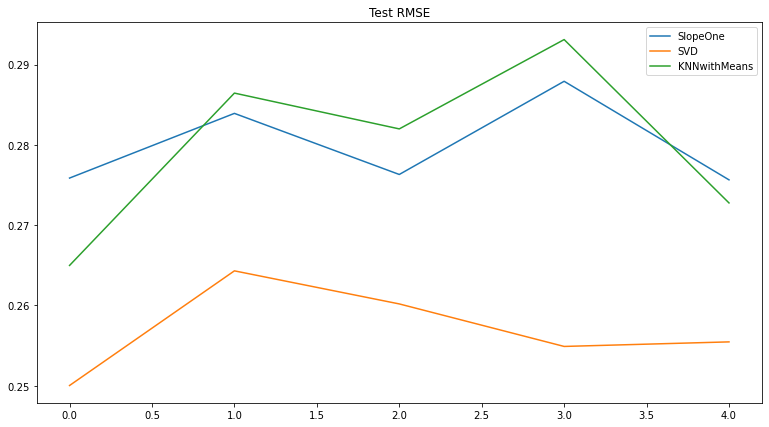

In [161]:
fig,ax = plt.subplots(figsize=(13,7))
ax.plot(so_validate["test_rmse"])
ax.plot(svd_validate["test_rmse"])
ax.plot(knn_validate["test_rmse"])
# plt.xticks(np.arange(0, 30, 0.5))
plt.title("Test RMSE", loc="center")
plt.legend(["SlopeOne","SVD","KNNwithMeans"])

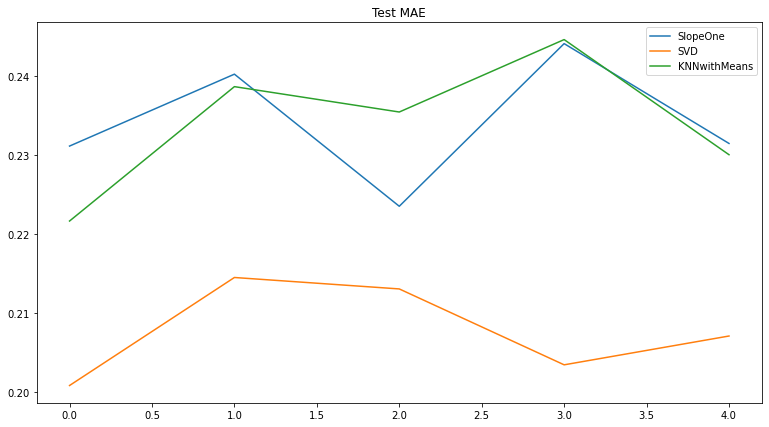

In [162]:
fig,ax = plt.subplots(figsize=(13,7))
ax.plot(so_validate["test_mae"])
ax.plot(svd_validate["test_mae"])
ax.plot(knn_validate["test_mae"])
# plt.xticks(np.arange(0, 4, 0.2))
plt.title("Test MAE", loc="center")
plt.legend(["SlopeOne","SVD","KNNwithMeans"])